In [40]:
from data import data
from reservoir import reservoir as res
import matplotlib.pyplot as plt
import numpy as np
from error import error
plt.rcParams["figure.facecolor"] = "white"

In [41]:
initial_condition = [1, -1, 2]
steps = 10000
transient = 5000

In [42]:
no_transient = data.generate_lorenz_63(
    initial_state=initial_condition,
    steps=steps,
    transient=0
)

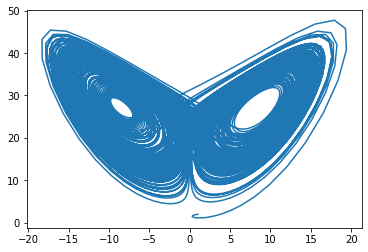

In [43]:
plt.figure(facecolor="white")
plt.plot(no_transient[:, 0], no_transient[:, 2])

In [44]:
with_transient = data.generate_lorenz_63(
    initial_state=initial_condition,
    steps=steps,
    transient=transient
)

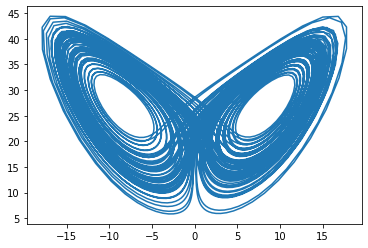

In [45]:
plt.figure(facecolor="white")
plt.plot(with_transient[:, 0], with_transient[:, 2])

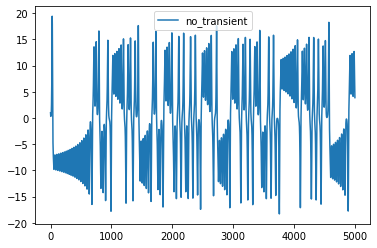

In [46]:
plt.figure(facecolor="white")
plt.plot(no_transient[:transient, 0], label="no_transient")

plt.legend()

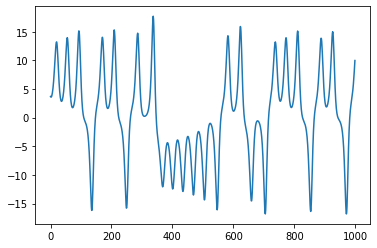

In [47]:
plt.plot(with_transient[:1000, 0], label="with_transient")

In [67]:
hyperparams = {
    'GAMMA': 7.7,
    'SIGMA': 0.81,
    'RHO_IN': 0.37,
    'K': 3,
    'RHO_R': 0.41,
    'N': 100
}

simulation_parameters = {
    "DEL_T": 0.02,          # time step size
    "STEPS": 30000,         # total steps
    "WASHOUT": 10000,       # washout 
    # n = STEPS - WASHOUT
    "ALPHA": 0.001,         # Tikhonov regularisation constant
    "d": 3,
    "INITIAL_STATE_RANGE": 5
}

STATE = np.random.RandomState(20)

training_initial_condition = STATE.choice(np.linspace(-5, 5, 50), 3)
test_initial_condition = STATE.choice(np.linspace(-5, 5, 50), 3)
training_data = data.generate_lorenz_63(
    initial_state=training_initial_condition,
    steps=simulation_parameters['STEPS'],
    transient=simulation_parameters["WASHOUT"]
)
test_data = data.generate_lorenz_63(
    initial_state=test_initial_condition,
    steps=simulation_parameters['STEPS'],
    transient=simulation_parameters["WASHOUT"]
)


In [68]:
N = hyperparams["N"]
d = 3
DEL_T = simulation_parameters["DEL_T"]
ALPHA = simulation_parameters["ALPHA"]
LAMBDA = 0.9056

In [69]:
# construct reservoir internals
W_in = res.generate_W_in(hyperparams=hyperparams, shape=(N, d), state=STATE)
W_r = res.generate_W_r(hyperparams=hyperparams, shape=(N, N), state=STATE)

unmodified_training_res = res.generate_training_reservoir(
    data=training_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    delta_t=DEL_T,
    adjust_for_symmetry=False
)

# form training reservoir
training_res = res.generate_training_reservoir(
    data=training_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    delta_t=DEL_T,
    adjust_for_symmetry=True
)

# train W_out
W_out = res.generate_W_out(
    data=training_data,
    res=training_res,
    alpha=ALPHA
)

In [70]:
# construct forecast reservoir
unmodified_forecast_res, forecast_res = res.generate_forecast_reservoir(
    r_0 = np.dot(W_in, test_data[0]),
    # r_0 = unmodified_training_res[-1],
    data=test_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    W_out=W_out,
    delta_t=DEL_T,
    adjust_for_symmetry=True
)

In [71]:
preds = res.readout_network(res=forecast_res, W_out=W_out)

In [72]:
new_initial_condition = preds[-1]
new_test_data = data.generate_lorenz_63(
    initial_state=new_initial_condition,
    steps=simulation_parameters['STEPS'],
    transient=0
)

In [73]:
new_unmodified_forecast_res, new_forecast_res = res.generate_forecast_reservoir(
    r_0 = unmodified_forecast_res[-1],
    data=new_test_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    W_out=W_out,
    delta_t=DEL_T,
    adjust_for_symmetry=True
)

In [74]:
(unmodified_forecast_res[-1] == new_forecast_res[0])[51]

False

In [75]:
new_preds = res.readout_network(new_forecast_res, W_out)

In [76]:
print(new_initial_condition)
print(new_test_data[0])
print(new_preds[0])

[20.35506442 37.3954664   8.89115811]
[20.35506442 37.3954664   8.89115811]
[20.35506442 37.3954664   8.89115811]


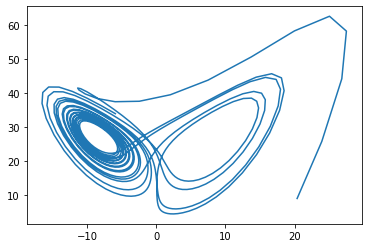

In [77]:
start = data.lyapunov_to_steps(0, LAMBDA, DEL_T)
end = data.lyapunov_to_steps(15, LAMBDA, DEL_T)
x_range = LAMBDA * DEL_T * np.array(range(start, end))
plt.plot(new_test_data[start:end, 0], new_test_data[start:end, 2])

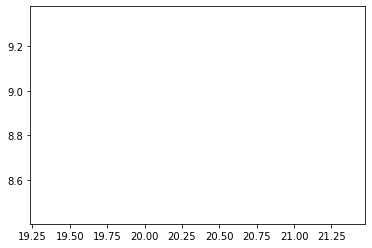

In [78]:
plt.plot(new_preds[start:end, 0], new_preds[start:end, 2])

Text(0, 0.5, 'x')

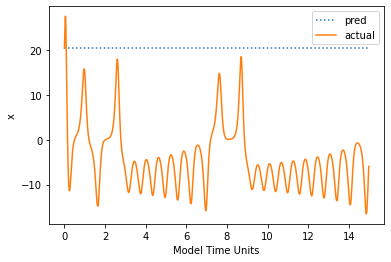

In [79]:
plt.plot(x_range, new_preds[start:end, 0], label="pred", linestyle="dotted")
plt.plot(x_range, new_test_data[start:end, 0], label="actual")
plt.legend()
plt.xlabel("Model Time Units")
plt.ylabel("x")

Text(0, 0.5, 'y')

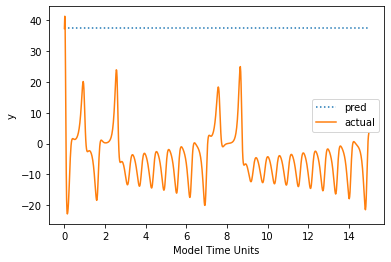

In [80]:
plt.plot(x_range, new_preds[start:end, 1], label="pred", linestyle="dotted")
plt.plot(x_range, new_test_data[start:end, 1], label="actual")
plt.legend()
plt.xlabel("Model Time Units")
plt.ylabel("y")

Text(0, 0.5, 'z')

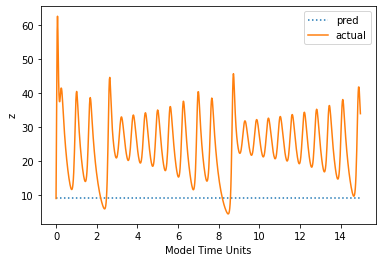

In [81]:
plt.plot(x_range, new_preds[start:end, 2], label="pred", linestyle="dotted")
plt.plot(x_range, new_test_data[start:end, 2], label="actual")
plt.legend()
plt.xlabel("Model Time Units")
plt.ylabel("z")

In [82]:
error.RMSE(new_test_data, new_preds)

array([1.57554741, 2.74392344, 1.19469693])

In [83]:
error.griffith_epsilon_1(new_test_data, new_preds, delta_t=0.02, LAMBDA=LAMBDA)

0.03259927536256284

In [84]:
error.griffith_epsilon(new_test_data, new_preds, delta_t=0.02, LAMBDA=LAMBDA)

0.758066559980079